# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Authors:** Claire Meyer, Nicolas Furrer, Philipp Schuler  
**Due date:** 26.03.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extracting relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [3]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, "data")
data_folder = "lab-01-data"
#tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
#with tarfile.open(tar_path, mode='r:gz') as tar:
#    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

Done


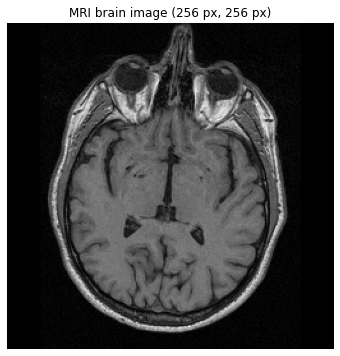

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

import cv2 as cv
import numpy as np

# Load image with OpenCV
data_path = os.path.join(data_base_path, data_folder)
original_img = cv.imread(os.path.join(data_path, "brain-slice40.tiff"),0)
height, width = original_img.shape[:2]

# Plot image
n_lin = 1
n_col = 1
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))
ax.imshow(original_img, cmap="gray")
ax.set_title("MRI brain image ({} px, {} px)".format(height,width))
ax.axis("off")

#End of cell
print("Done")

### 1.2 Region growing
<!-- Add your implementation and discussion -->

In order to compute the size of the brain using region growing, we start from the original image, $I_1$, and compute the subsequent images :
- $I_2$, by doing region growing on $I_1$, the original image. We obtain the original image superimposed with the mask of the brain surface. The OpenCV function used, `cv.floodFill(image, mask, seedPoint, newVal, loDiff, upDiff)`, also fill the argument `mask` with the mask of the brain surface, but that mask is bigger than the original image (if original image is $n$ x $n$, then the mask is ($n$+2) x ($n$+2), and the padding is filled with the filling value, so here, white (255).
- $I_3$, by cropping the mask obtained at the previous steop. We just need to remove the aforementionned padding. We obtain a mask of the brain surface (brain surface is white on black background).

From there, we just count how many pixels are white in $I_3$, the mask, to have the size of the brain in pixels. To verify the quality of the result, we also compute $I_4$, by superimposing $I_3$, the mask of the brain, on $I_1$, the original image. It allows us to assess that the brain surface is indeed correct with visual proof.

<br>

All the steps from the original image to the brain mask and the quality control image (from $I_1$ to $I_4$) are displayed below, along with the implementation :

In [ ]:
# Region growing from pixel (150,150)
grown_img = original_img.copy()
seed = (150,150)
t1 = 6
t2 = 15
mask = np.zeros((height+2,width+2), np.uint8)
cv.floodFill(image=grown_img, mask=mask, seedPoint=seed, newVal=255, loDiff=t1, upDiff=t2)

# Getting the mask back
brain_mask = mask[1:width+1,1:height+1].copy()*255
cv.imwrite(filename="test.png", img=brain_mask)

# Superimposition
empty_mask = np.zeros((height, width), np.uint8)
color_brain_mask = cv.merge(mv=(empty_mask, empty_mask, brain_mask))
color_original_img = cv.cvtColor(original_img, code=cv.COLOR_GRAY2RGB)
superimposed_img = cv.add(src1=color_brain_mask, src2=color_original_img)

# Number of pixels
n = np.sum(brain_mask == 255)

# Hyperparameters :
print(f"Hyperparamters : ")
print(f"    Seed at {seed}.")
print(f"    Max lower difference : {t1}.")
print(f"    Max upper difference : {t2}.")

# Results
print(f"Results : ")
print(f"    Size of the brain : {n} px in the {height}x{width} image.")
print(f"    Percentage of area occupied by the brain in the image : {n*100/(width*height):.2f}%.")

# Plots
n_lin = 2
n_col = 2
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

ax[0,0].imshow(original_img, cmap = 'gray')
ax[0,0].set_title("$I_1$ : Original image")

ax[0,1].imshow(grown_img, cmap = 'gray')
ax[0,1].set_title("$I_2$ : Region growing result")

ax[1,0].imshow(brain_mask, cmap = 'gray')
ax[1,0].set_title("$I_3$ : Mask of brain surface")

ax[1,1].imshow(superimposed_img, cmap = 'gray')
ax[1,1].set_title("$I_4$ : Control image (mask on original image)")

for a in ax.flatten():
    a.axis("off")

#End of cell
print("Done")

The result indicates that the surface of the brain is of 15667 px, which corresponds to 23.91% of the image size, as can be seen just above. $I_4$, the quality control image, also shows that the segmentation is good, and thus that the result can be trusted.

<br>

This method requires three meta parameters :
- An initial seed for the region growing, to begin the the flood-filling from. In order to find the surface of the brain, that seed needs to be located somewhere within that area. Thus, it can take many values, as long as the coordinates are within the surface of the brain. Here, they were chosen by estimation with the naked eye (trial and error), and ($x$,$y$)=(150,150) is such a coordinate.
- A lower and upper brightness difference beetween the currently observed pixel (pixel at $(x,y)$) and one of its neighbors belonging to the component, or a seed pixel being added to the component (pixel at $(x',y')$). Here, we determine that the next pixel belong to the region if :
    $$\texttt{src} (x',y')- \texttt{loDiff} \leq \texttt{src} (x,y) \leq \texttt{src} (x',y')+ \texttt{upDiff}$$
    Here, the lower difference is 6, and the upper difference is 15. It means that a pixel is much more easily added to the growing region if the brightness is higher, than if the brightness is lower, as the empty zones between the brain and the skull are darker.

### 1.3 Contour detection
<!-- Add your implementation and discussion -->

In order to compute the size of the brain using contour detection, we start from the original image, $I_1$, and compute the subsequent images :
- $I_2$, by applying the Canny algorithm on $I_1$, the original image. We obtain the contours of the original image. But those contours are not closed, they are just edges from the original image. To determine a region (here, the brain), we need the contour around that region closed (the other contours don't matter).
- $I_3$, by dilating $I_2$, the contours. We obtained closed contours, because the dilation of the contours make them grow. Thus, the area containing the brain is determined by a closed contour.
- $I_4$, by flooding $I_3$, the closed contours, with a initial seed in the brain. We obtain a compound black image, with the closed dilated contours and the brain surface in white. Indeed, flooding fills a zone on the basis of a continuous color (or here, lack thereof, because we flood an area of pixel value 0). Because we fill from the inside of the brain (black), and the brain is closed by closed contours (white), after flood-filling, the brain is white. It is the same function from OpenCV than the one used in the region growing part; but the difference is that here, we do not set the lower and upper difference. Thus they are the default, which is 0. It means that it is no longer a region growing, but a flooding (only exactly the same color is filled).
- $I_5$, by performing the "NOT" bitwise operation on $I_4$. We obtain a compound white image, with the closed dilated contours and the brain surface in black. The operations to obtain $I_5$ and $I_6$ are just logical operations on the images, to obtain what we want.
- $I_6$, by performing the "OR" bitwise operation on $I_3$ and $I_5$. Since $I_3$ contains the closed dilated contours, and $I_5$ anything but the contours and the brain surface, we obtain a white image with the brain surface in black. That brain surface is eroded compared to the real size, because of the previous dilation (of the edges of the brain).
- $I_7$, by eroding $I_6$. We obtain a white image with the brain in black, but this time the correct surface. We need this erosion because we had to dilate $I_2$, to close the contours. This dilation "ate away" at the brain, so now we need to "grow it back up". This is done by erosion because the brain is in black, not in white. 
- $I_8$, by performing the "NOT" bitwise operation on $I_7$. We obtain a mask of the brain surface (brain surface is white on black background).

From there, we just count how many pixels are white in $I_8$, the mask, to have the size of the brain in pixels. To verify the quality of the result, we also compute $I_9$, by superimposing $I_8$, the mask of the brain, on $I_1$, the original image. It allows us to assess that the brain surface is indeed correct with visual proof.

<br>

All the steps from the original image to the brain mask and the quality control image (from $I_1$ to $I_9$) are displayed below, along with the implementation :

In [ ]:
# Canny detection 
t1 = 85
t2 = 200
edges_img = cv.Canny(image=original_img, threshold1=t1, threshold2=t2, apertureSize=3)

# Dilation of contours
kernel = np.zeros((3,3), np.uint8)
cv.circle(img=kernel, center=(1,1), radius=1, color=255, thickness=-1) 
dilated_edges_img = cv.dilate(edges_img, kernel, iterations=1)

# Flood-filling from pixel (150, 150)
mask = np.zeros((height+2, width+2), np.uint8)
flooded_img = dilated_edges_img.copy()
seed = (150,150)
cv.floodFill(flooded_img, mask, seed, 255);

# Inversion of the flood filled image 
inverted_flooded_img = cv.bitwise_not(flooded_img)

# Combination of the thresholded image with the inverted flood filled image using bitwise OR operation 
dilated_segmented_img = cv.bitwise_or(dilated_edges_img, inverted_flooded_img)
segmented_img = cv.erode(dilated_segmented_img, kernel, iterations=1)

# Brain mask
brain_mask = cv.bitwise_not(segmented_img)

# Superimposition
empty_mask = np.zeros((height, width), np.uint8)
color_brain_mask = cv.merge(mv=(empty_mask, empty_mask, brain_mask))
color_original_img = cv.cvtColor(original_img, code=cv.COLOR_GRAY2RGB)
superimposed_img = cv.add(src1=color_brain_mask, src2=color_original_img)

# Number of pixels
n = np.sum(brain_mask == 255)

# Hyperparameters :
print(f"Hyperparamters : ")
print(f"    Low Canny threshold : {t1}.")
print(f"    High Canny threshold : {t2}.")
print(f"    Seed at {seed}.")

# Results
print(f"Results : ")
print(f"    Size of the brain : {n} px in the {height}x{width} image.")
print(f"    Percentage of area occupied by the brain in the image : {n*100/(width*height):.2f}%.")

# Plots
n_lin = 3
n_col = 3
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

ax[0,0].imshow(original_img, cmap = 'gray')
ax[0,0].set_title("$I_1$ : Original image")

ax[0,1].imshow(edges_img, cmap = 'gray')
ax[0,1].set_title("$I_2$ : Contours of original image")

ax[0,2].imshow(dilated_edges_img, cmap = 'gray')
ax[0,2].set_title("$I_3$ : Closed, dilated contours")

ax[1,0].imshow(flooded_img, cmap = 'gray')
ax[1,0].set_title("$I_4$ : Closed, dilated contours and brain surface in white")

ax[1,1].imshow(inverted_flooded_img, cmap = 'gray')
ax[1,1].set_title("$I_5$ : Closed, dilated contours and brain surface in black")

ax[1,2].imshow(dilated_segmented_img, cmap = 'gray')
ax[1,2].set_title("$I_6$ : Mask of everything but brain \n(the brain is a little bit eroded away\nbecause of the dilation at the third step)")

ax[2,0].imshow(segmented_img, cmap = 'gray')
ax[2,0].set_title("$I_7$ : Mask of brain surface (inverted)")

ax[2,1].imshow(brain_mask, cmap = 'gray')
ax[2,1].set_title("$I_8$ : Mask of brain surface")

ax[2,2].imshow(superimposed_img, cmap = 'gray')
ax[2,2].set_title("$I_9$ : Control image (mask on original image)")

for a in ax.flatten():
    a.axis("off")

#End of cell
print("Done")

The result indicates that the surface of the brain is of 15742 px, which corresponds to 24.02% of the image size, as can be seen just above. $I_9$, the quality control image, also shows that the segmentation is good, and thus that the result can be trusted.

<br>

This method requires a few meta parameters :
- $t_1$ and $t_2$, the thresholds for the Canny edges detector. Those two threshold mark the strong and weak edges : anything above the highest threshold is a strong edge, anything below the lowest threshold is deleted, and the rest is a weak edge, whose validity is determined by its link, or lack thereof, to a strong edge. Those values are determined empirically, and influence drastically the result of the edge detection. Here, we chose $t_1$=85 and $t_2$=200.
- The dilation kernel is also quite important. If too small, the dilation doesn't close the edges. If too big, some edges that should remain separate become fused. Here, the kernel is a circle of radius 1, which is equivalent to a cross on a 3x3 matrix. To ensure some degree of consistency, the same kernel is used for the subsequent erosion.
- Similarly, the dilation iteration number, if too high, can fuse edges that should remain separate. Here, we only iterated the dilation once; and thus we only eroded once as well, for consistency.
- The flooding necessitates an initial seed, to begin the the flooding from. In order to find the surface of the brain, that seed needs to be located somewhere within that area. Thus, it can take many values, as long as the coordinates are within the surface of the brain. Here, they were chosen by estimation with the naked eye (trial and error), and ($x$,$y$)=(150,150) is such a coordinate.

<br>

Initially, we tried an histogram equalization on the original image, to see if we could determine the edges more acurately that way. It proved to be severely unhelpful, to the point of being deleterious to the result. When looking at the result of an histogram equalization, we can easily see why. Indeed a lot of noise is enhanced by the equalization, to the point where there are way too many false positive when trying to detect the edges with the Canny algorithm. Below are shown the original image, the histogram equalization of that original image, and the edges detected with the Canny algorithm from that equalized image :

In [ ]:
# Histogram equalization 
equalized_img = cv.equalizeHist(original_img)

# Canny detection 
t1 = 240
t2 = 245
edges_img_2 = cv.Canny(image=equalized_img,threshold1=t1,threshold2=t2,apertureSize=3)

# Plots
n_lin = 1
n_col = 3
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

ax[0].imshow(original_img, cmap = 'gray')
ax[0].set_title("Original image")

ax[1].imshow(equalized_img, cmap = 'gray')
ax[1].set_title("Equalized original image")

ax[2].imshow(edges_img_2, cmap = 'gray')
ax[2].set_title("Contours detected on equalized image")

for a in ax.flatten():
    a.axis("off")

#End of cell
print("Done")

In order to try and detect only the strongest edges, the Canny thresholds are set very high, to keep only the strongest of edges, but there are still too many false positive : the histogram equalization broke the edges on the original image.

### 1.4 Active contours
<!-- Add your implementation and discussion -->

In order to compute the size of the brain using active contours, we initialize an initial snake around the brain, and then warp it to closely stick to the brain surface edge. From it, we compute the area within the snake using the Green theorem.

<br>

All the steps are displayed below, along with the implementation :

In [ ]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# Area calculation with green theorem :
# Source: https://stackoverflow.com/questions/22678990/how-can-i-calculate-the-area-within-a-contour-in-python-using-the-matplotlib
def area(vs):
    area = 0
    x0,y0 = vs[0]
    for [x1,y1] in vs[1:]:
        dx = x1-x0
        dy = y1-y0
        area += 0.5*(y0*dx - x0*dy)
        x0 = x1
        y0 = y1
    return area

# Initialisation of the snake as a circle centered around the brain
center = (147, 125)
radius = 75
samples = np.linspace(0, 2*np.pi, 400)
sine = center[0] + radius*np.sin(samples)
cosine = center[1] + radius*np.cos(samples)
initial_snake = np.array([sine, cosine]).T

# Gaussian blur
blurred_img = gaussian(original_img, 1)

# Active contour detection 
beta_val = 4
line_val = -5
edge_val = 10
final_snake_original = active_contour(original_img, initial_snake, beta=beta_val, w_line=line_val, w_edge=edge_val, coordinates='rc')

# Number of pixels
n_original = int(area(final_snake_original))

# Hyperparameters :
print(f"Hyperparamters : ")
print(f"    Initial snake center : {center}.")
print(f"    Initial snake radius : {radius}.")
print(f"    Active contour beta value : {beta_val}.")
print(f"    Active contour w line value : {line_val}.")
print(f"    Active contour w edge value : {edge_val}.")

# Results
print(f"Results : ")
print(f"    Size of the brain : {n_original} px in the {height}x{width} image.")
print(f"    Percentage of area occupied by the brain in the image : {n_original*100/(width*height):.2f}%.")

# Plots
n_lin = 1
n_col = 2
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

ax[0].imshow(original_img, cmap = 'gray')
ax[0].plot(initial_snake[:, 1], initial_snake[:, 0], '--r', lw=3)
ax[0].set_title("$I_1$ : Initial snake")

ax[1].imshow(original_img, cmap = 'gray')
ax[1].plot(final_snake_original[:, 1], final_snake_original[:, 0], '-b', lw=3)
ax[1].set_title("$I_2$ : Final snake")

for a in ax.flatten():
    a.axis("off")

#End of cell
print("Done")

The result indicates that the surface of the brain is of 19259 px, which corresponds to 29.39% of the image size, as can be seen just above. 
The active contour may not be the best choice in this situation, as we are trying to get the grey zone out of the other different grey zone; on $I_2$ we can see that the snake doesn't stick as closely to the edge of the brain surface as the previous methods.
We also have a lot of holes that we want to detect. That could be done with multiple active contour detections just for the holes. 

<br>

This method requires a few meta parameters :
- The initial snake position; the closer it is to the final snake, the better.
- Beta, the smoothness of the line. We don't want to be too smooth as the brain has lots of folds.
- `w_line`, the attraction to brightness. Here we want to keep away from the brighter areas and try to stay in the dark zones between the brain and the skull.
- `w_edge`, the attraction to the edges. We want to stick as much as possible to edges.

Those meta parameters allow to miss very few parts of the brain, but include some that shouldn't be.

### 1.4 Thresholding
<!-- Add your implementation and discussion -->

In order to compute the size of the brain using contour detection, we start from the original image, $I_1$, and compute the subsequent images :
- $I_2$, by equalizing $I_1$'s histogram, the original image. We obtain an image with values more spread on the dynamic available.
- $I_3$, by thresholding $I_2$, the histogram equilized version of the original image. Ideally, we want at that stage to have the brain as a single region, separate from the other regions on the image. Unfortunately, that's not the case, and on the images below, it is visible that the right ocular region is attached to the brain after thresholding. It doesn't matter, because we can get rid of it at the next step.
- $I_4$, by eroding $I_3$, the thresholded image, with a 3 x 3 kernel presenting a circle of radius 1 (i.e., a cross). We iterate the erosion until the ocular region is cut from the brain, that is three times. We obtain an eroded thresholded image, where the brain is one region, separate from the rest.
- $I_5$, by flooding $I_4$, where the brain was isolated, with a initial seed withing the brain area. The two next steps are bitwise operations similar to the method with contour detection.
- $I_6$, by performing the "NOT" bitwise operation on $I_5$. 
- $I_7$, by performing the "AND" bitwise operation on $I_6$ and $I_4$. We obtain an eroded version of the brain mask. To restore the correct brain mask, $I_8$, we just need one last step.
- $I_8$, by dilating $I_7$, the eroded brain mask. We obtain a mask of the brain surface (brain surface is white on black background). We use the same kernel as for the erosion, and the same number of iterations.

From there, we just count how many pixels are white in $I_8$, the mask, to have the size of the brain in pixels. To verify the quality of the result, we also compute $I_9$, by superimposing $I_8$, the mask of the brain, on $I_1$, the original image. It allows us to assess that the brain surface is indeed correct with visual proof.

<br>

All the steps from the original image to the brain mask and the quality control image (from $I_1$ to $I_9$) are displayed below, along with the implementation :

In [ ]:
# Histogram equalization 
equalized_img = cv.equalizeHist(original_img)

# Plain threshold 
threshold = 127
_, thresholded_img = cv.threshold(src=equalized_img, thresh=threshold, maxval=255, type=cv.THRESH_BINARY)

cv.imwrite("test.png", thresholded_img)

# Erosion to cut the right eye
iterations_num = 3
kernel = np.zeros((3,3), np.uint8)
cv.circle(img=kernel, center=(1,1), radius=1, color=255, thickness=-1) 
eroded_thresholded_img = cv.erode(thresholded_img, kernel, iterations=iterations_num)

# Flood-filling from pixel (150, 150)
mask = np.zeros((height+2, width+2), np.uint8)
flooded_img = eroded_thresholded_img.copy()
seed = (150,150)
cv.floodFill(flooded_img, mask, seed, 0);

# Inversion of the flood filled image 
eroded_inverted_flooded_img = cv.bitwise_not(flooded_img)

# Combination of the thresholded image with the inverted flood filled image using bitwise AND operation 
eroded_brain_mask = cv.bitwise_and(eroded_inverted_flooded_img, eroded_thresholded_img)

# Dilation to grow back the missing bits
brain_mask = cv.dilate(eroded_brain_mask, kernel, iterations=iterations_num)

# Superimposition
empty_mask = np.zeros((height, width), np.uint8)
color_brain_mask = cv.merge(mv=(empty_mask, empty_mask, brain_mask))
color_original_img = cv.cvtColor(original_img, code=cv.COLOR_GRAY2RGB)
superimposed_img = cv.add(src1=color_brain_mask, src2=color_original_img)

# Number of pixels
n = np.sum(brain_mask == 255)

# Hyperparameters :
print(f"Hyperparamters : ")
print(f"    Threshold value : {threshold}.")
print(f"    Number of erosions / dilations : {iterations_num}.")
print(f"    Seed at {seed}.")

# Results
print(f"Results : ")
print(f"    Size of the brain : {n} px in the {height}x{width} image.")
print(f"    Percentage of area occupied by the brain in the image : {n*100/(width*height):.2f}%.")

# Plots
n_lin = 3
n_col = 3
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

ax[0,0].imshow(original_img, cmap = 'gray')
ax[0,0].set_title("$I_1$ : Original image")

ax[0,1].imshow(equalized_img, cmap = 'gray')
ax[0,1].set_title("$I_2$ : Histogram equalized image")

ax[0,2].imshow(thresholded_img, cmap = 'gray')
ax[0,2].set_title("$I_3$ : Thresholded image")

ax[1,0].imshow(eroded_thresholded_img, cmap = 'gray')
ax[1,0].set_title("$I_4$ : Eroded thresholded image")

ax[1,1].imshow(flooded_img, cmap = 'gray')
ax[1,1].set_title("$I_5$ : Flooded eroded thresholded \nimage with 0 in brain")

ax[1,2].imshow(eroded_inverted_flooded_img, cmap = 'gray')
ax[1,2].set_title("$I_6$ : Inverted eroded flooded brain")

ax[2,0].imshow(eroded_brain_mask, cmap = 'gray')
ax[2,0].set_title("$I_7$ : Eroded mask of brain surface ($I_4$ & $I_6$)")

ax[2,1].imshow(brain_mask, cmap = 'gray')
ax[2,1].set_title("$I_8$ : Mask of brain surface")

ax[2,2].imshow(superimposed_img, cmap = 'gray')
ax[2,2].set_title("$I_9$ : Control image (mask on original image)")

for a in ax.flatten():
    a.axis("off")

#End of cell
print("Done")

The result indicates that the surface of the brain is of 16570 px, which corresponds to 25.28% of the image size, as can be seen just above. $I_9$, the quality control image, also shows that the segmentation is good, and thus that the result can be trusted.

<br>

This method requires a few meta parameters :
- The first is the threshold value for the thresholding. Too high, and not all the brain is one piece during this crucial part of the segmentation. Too low, and bit of other cranial structures are attached to the brain. Unfortunately, the "too high" value is lower than the "too low" value, so we have to choose between the brain in its entierety but with bits of occular region attached, and the brain in several parts. Since it's easier to get rid of the occular parts later, we chose a value at which the brain is in one piece. Initially, we tried the Otsu threshold, which maximize inter-class variance, and minimizes intra-class variance; but it's just not a good threshold for this application.
- The erosion kernel is also quite important. If it's too big, then the risk is to detach parts of the brain. That's why it's a cross on a 3 x 3 matrix. The same kernel is later used for the dilation to restore back the brain region.
- The number of iterations to the dilation is dictated by need : it's the minimum number of iterations needed to detach the right occular region from the brain. The brain region, when segmented, is dilated the same number of time, to restore back the correct zone.
- The flood-fill necessitates an initial seed, to begin the the flood-filling from. In order to find the surface of the brain, that seed needs to be located somewhere within that area. Thus, it can take many values, as long as the coordinates are within the surface of the brain. Here, they were chosen by estimation with the naked eye (trial and error), and ($x$,$y$)=(150,150) is such a coordinate.

<br>

Initially, the histogram equalization showed that 0-padding wide of 26 px was added to the original image. Because this adds artificial pixels of value 0 to the image, we wondered how it affected the histogram equalization. Thus, we equalized on the whole original image, and on a ROI of the original image, to see the difference :

In [ ]:
# Histogram equalization on the whole image
equalized_img = cv.equalizeHist(original_img)

# Histogram equalization with ROI
d = 26
equalized_roi = original_img.copy()
equalized_roi[:,d:width-d] = cv.equalizeHist(original_img[:,d:width-d])

# Difference 
print(f"Results : ")
print(f"    Norm of error between with ROI and without : {cv.norm(equalized_img, equalized_roi)}")

# Histograms 
hist_original, bins_original = np.histogram(a = original_img , bins = 256, range=[0,256])
hist_equa_img, bins_equa_img = np.histogram(a = equalized_img, bins = 256, range=[0,256])
hist_equa_roi, bins_equa_roi = np.histogram(a = equalized_roi, bins = 256, range=[0,256])

# Normalized cumulative distribution functions
cdf_original = hist_original.cumsum() 
cdf_equa_img = hist_equa_img.cumsum() 
cdf_equa_roi = hist_equa_roi.cumsum() 

cdf_original = cdf_original * hist_original.max() / cdf_original.max()
cdf_equa_img = cdf_equa_img * hist_equa_img.max() / cdf_equa_img.max()
cdf_equa_roi = cdf_equa_roi * hist_equa_roi.max() / cdf_equa_roi.max()

# Plots
n_lin = 2
n_col = 3
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

ax[0,0].imshow(original_img, cmap = 'gray')
ax[0,0].set_title("Original image")

ax[0,1].imshow(equalized_img, cmap = 'gray')
ax[0,1].set_title("Equalized without ROI")

ax[0,2].imshow(equalized_roi, cmap = 'gray')
ax[0,2].set_title("Equalized without ROI")

ax[1,0].plot(cdf_original, color = 'b')
ax[1,0].hist(original_img.flatten(),256,[0,256], color = 'r')
ax[1,0].set_title("Histogram of original image with CDF")
ax[1,0].set_xlim([0,256])

ax[1,1].plot(cdf_equa_img, color = 'b')
ax[1,1].hist(equalized_img.flatten(),256,[0,256], color = 'r')
ax[1,1].set_title("Histogram of equalized image without ROI, with CDF")
ax[1,1].set_xlim([0,256])

ax[1,2].plot(cdf_equa_roi, color = 'b')
ax[1,2].hist(equalized_roi.flatten(),256,[0,256], color = 'r')
ax[1,2].set_title("Histogram of equalized image with ROI, image with CDF")
ax[1,2].set_xlim([0,256])

for a in ax.flatten():
    a.axis("off")

#End of cell
print("Done")

Because the histogram of the original image is skewed on the left, and because of the inherent discrete nature of it, it doesn't impact the equalization, and they both give exactly the same result (the norm of the error between the two equlized histogram is 0). Had the values of the image without the padding been skewed on the right instead, it would have led to very distinct histograms.

<br>

Another trial (and error) experimented was an adaptive threshold. Adaptive thresholds work great on pictures which cast shadows, because the threshold is determined automatically from values from neighboring pixels, and maybe that thresholding method would segment better the brain from the skull. The downside is that it requires a new meta-parameter, namely how we determine which pixels are considered neighboring pixels. Here are the result of those investigations, along with the result from plain Otsu thresholding, to illustrate why we didn't keep those implementations :

In [ ]:
# Histogram equalization on the whole image
equalized_img = cv.equalizeHist(original_img)

# Otsu thresholding
_, otsu_img = cv.threshold(src=equalized_img, thresh=0, maxval=255, type=(cv.THRESH_BINARY | cv.THRESH_OTSU))

# Adaptive thresholding
maxVal=255
constant = 2

blocksize = 51
img_1 = cv.adaptiveThreshold(src=equalized_img, maxValue=maxVal, adaptiveMethod=cv.ADAPTIVE_THRESH_MEAN_C, thresholdType=cv.THRESH_BINARY, blockSize=11, C=constant)
img_2 = cv.adaptiveThreshold(src=equalized_img, maxValue=maxVal, adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType=cv.THRESH_BINARY, blockSize=11, C=constant)

blocksize = 151
img_3 = cv.adaptiveThreshold(src=equalized_img, maxValue=maxVal, adaptiveMethod=cv.ADAPTIVE_THRESH_MEAN_C, thresholdType=cv.THRESH_BINARY, blockSize=11, C=constant)
img_4 = cv.adaptiveThreshold(src=equalized_img, maxValue=maxVal, adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType=cv.THRESH_BINARY, blockSize=11, C=constant)

blocksize = 251
img_5 = cv.adaptiveThreshold(src=equalized_img, maxValue=maxVal, adaptiveMethod=cv.ADAPTIVE_THRESH_MEAN_C, thresholdType=cv.THRESH_BINARY, blockSize=11, C=constant)
img_6 = cv.adaptiveThreshold(src=equalized_img, maxValue=maxVal, adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType=cv.THRESH_BINARY, blockSize=11, C=constant)

# Plots
n_lin = 4
n_col = 2
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

ax[0,0].imshow(otsu_img, cmap = 'gray')
ax[0,0].set_title("Otsu threshold")

# ax[0,1].imshow(equalized_img, cmap = 'gray')
# ax[0,1].set_title("Equalized without ROI")

ax[1,0].imshow(img_1, cmap = 'gray')
ax[1,0].set_title("Adaptive mean theshold, blocksize of 51")

ax[1,1].imshow(img_2, cmap = 'gray')
ax[1,1].set_title("Adaptive gaussian theshold, blocksize of 51")

ax[2,0].imshow(img_3, cmap = 'gray')
ax[2,0].set_title("Adaptive mean theshold, blocksize of 151")

ax[2,1].imshow(img_4, cmap = 'gray')
ax[2,1].set_title("Adaptive gaussian theshold, blocksize of 151")

ax[3,0].imshow(img_5, cmap = 'gray')
ax[3,0].set_title("Adaptive mean theshold, blocksize of 251")

ax[3,1].imshow(img_6, cmap = 'gray')
ax[3,1].set_title("Adaptive gaussian theshold, blocksize of 251")

for a in ax.flatten():
    a.axis("off")

#End of cell
print("Done")

None of these threshold are as nice as the plain, hand-tuned threshold used (considering our application).

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

Number of images: 3
Image size : 480x640
Number of color channels : 3
Done


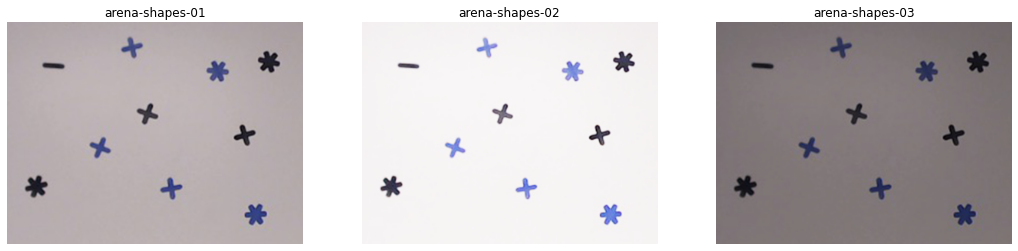

In [5]:
# Load images
img_names = ["arena-shapes-01", "arena-shapes-02", "arena-shapes-03"]
filenames = [os.path.join(data_path, name) + ".png" for name in img_names]
img_files = skimage.io.imread_collection(filenames)
imgs = skimage.io.concatenate_images(img_files)

# Print information
print(f"Number of images: {imgs.shape[0]}")
print(f"Image size : {imgs.shape[1]}x{imgs.shape[2]}")
print(f"Number of color channels : {imgs.shape[-1]}")

# Plots
n_lin = 1
n_col = 3
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

for a, img, name in zip(ax.flatten(), imgs, img_names):
    a.imshow(img)
    a.axis("off")
    a.set_title(name)

# End of cell
print("Done")

When looking at the RGB and HSV values from the three images for the blue, purple, and background, we obtain the following results.

For RGB values :

|            | arena-shapes-01 | arena-shapes-02 | arena-shapes-03 |
| ---------- | --------------- | --------------- | --------------- |
| Blue       | 110 , 130 , 227 | 110 , 130 , 227 | 032 , 041 , 088 |
| Black      | 032 , 032 , 048 | 034 , 033 , 049 | 021 , 021 , 031 |
| Background | 193 , 181 , 182 | 193 , 182 , 183 | 135 , 123 , 123 |

For HSV values :

|            | arena-shapes-01     | arena-shapes-02     | arena-shapes-03     |
| ---------- | ------------------- | ------------------- | ------------------- |
| Blue       | 229.0 , 53.3 , 88.9 | 232.8 , 51.7 , 89.0 | 230.4 , 63.8 , 34.5 |
| Black      | 242.1 , 28.4 , 16.8 | 250.3 , 37.9 , 39.1 | 242.2 , 34.8 , 12.5 |
| Background | 339.5 , 07.2 , 75.4 | 353.6 , 06.5 , 75.3 | 337.6 , 09.4 , 52.6 |


### 2.2 Number of shapes of each color
Add your implementation and discussion

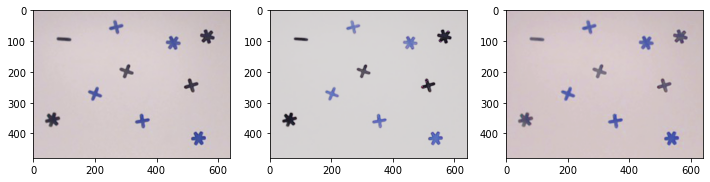

In [6]:
import cv2 as cv
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), imgs, img_names):
    
    im_hsv = cv.cvtColor(im, cv.COLOR_BGR2HSV)
    #ax.imshow(im_hsv)
    m = np.mean(im_hsv[:,:,2])
    mean = 210-m
    im_hsv[:,:,2] += np.uint8(mean)
    
    im_hsv = cv.cvtColor(im_hsv, cv.COLOR_HSV2BGR)
    
    ax.imshow(im_hsv)
    
plt.show()

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

Results : 
    They are 4016 black pixel and 5049 blue pixel  in area shape 01.
    They are 3991 black pixel and 5087 blue pixel  in area shape 02.
    They are 3995 black pixel and 5064 blue pixel  in area shape 03.


Text(0.5, 1.0, '$I_{37}$ : Morph operation 03')

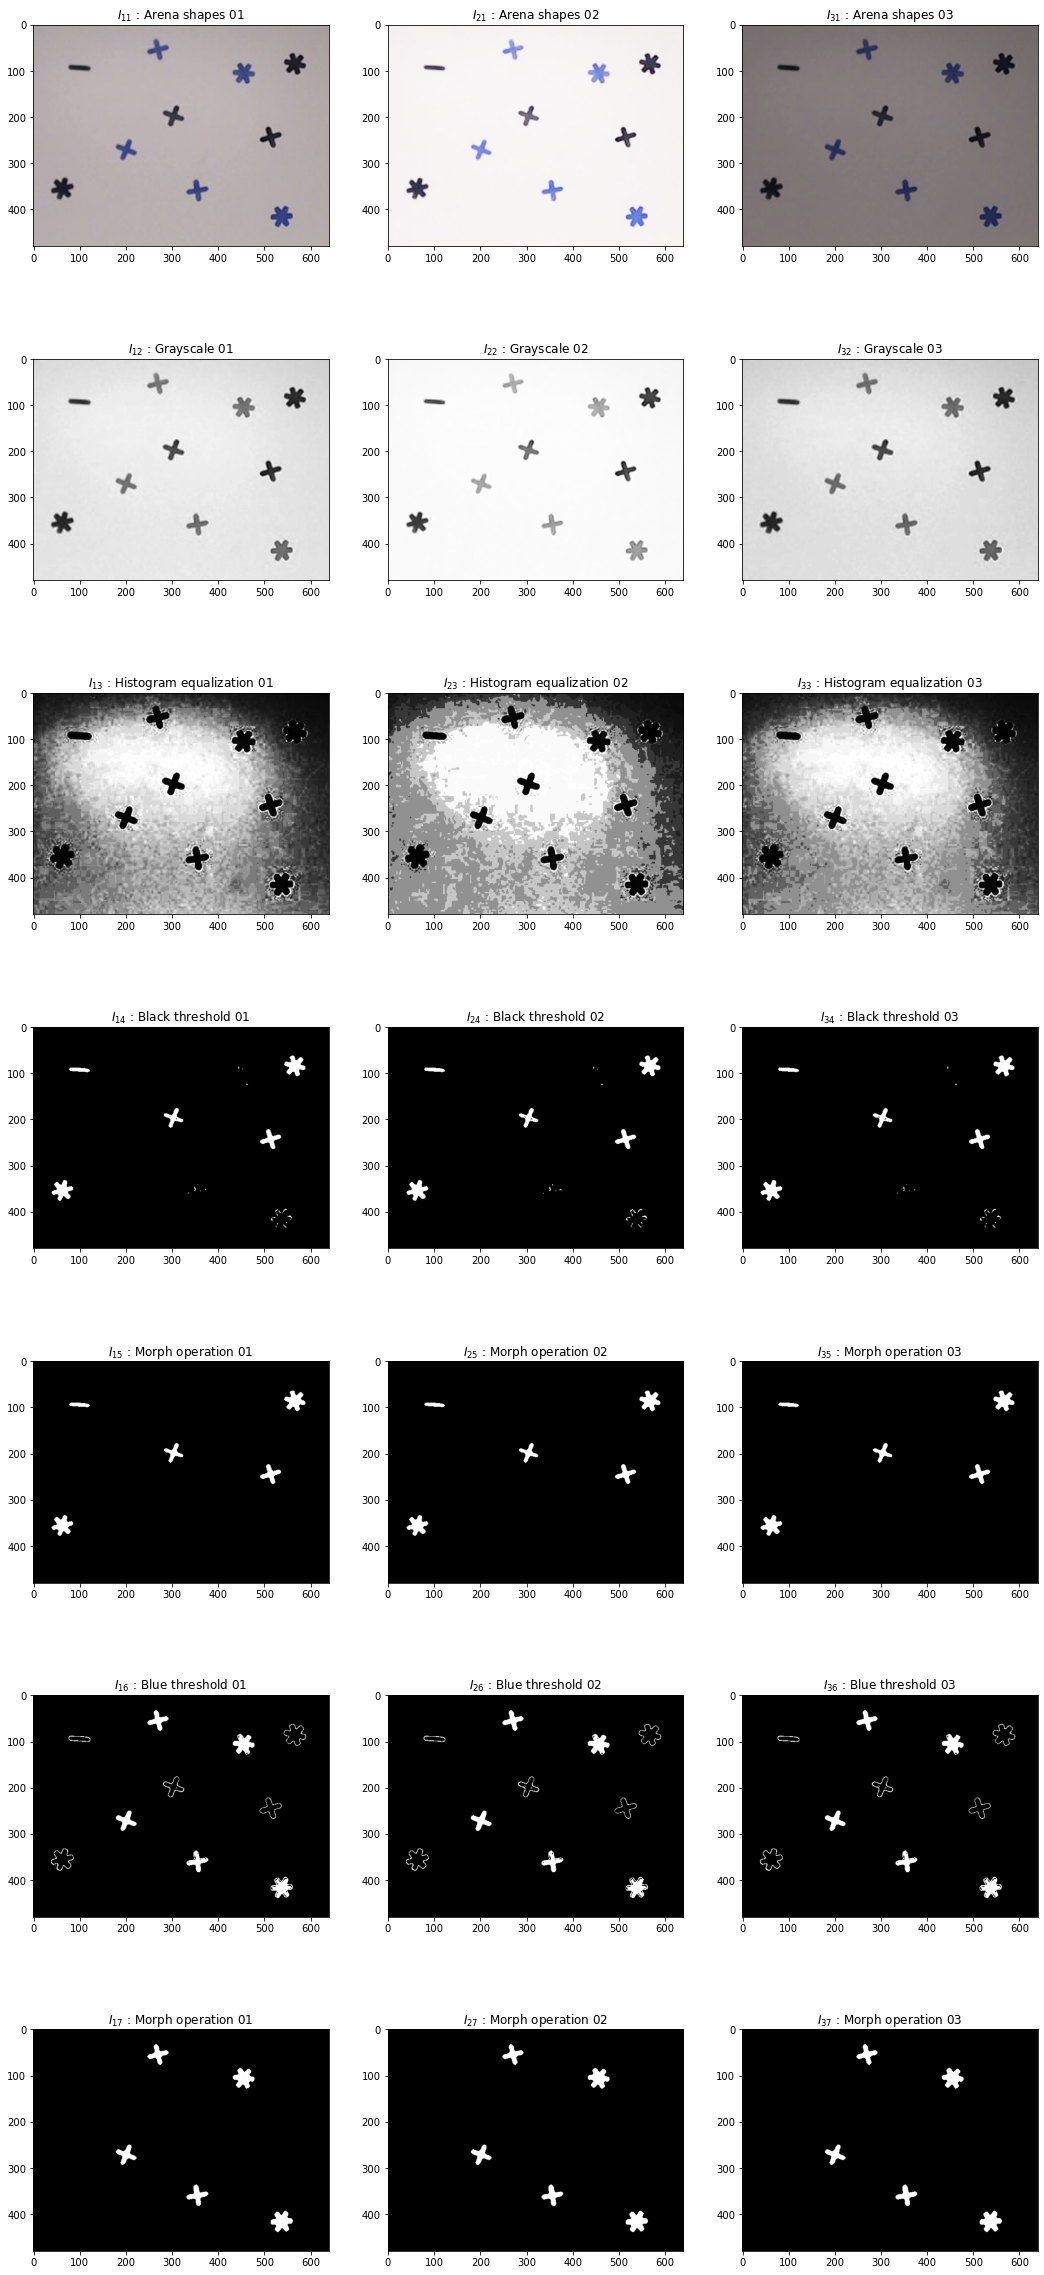

In [13]:
# Copy image for security
rgb_shapes_01 = imgs[0].copy()
rgb_shapes_02 = imgs[1].copy()
rgb_shapes_03 = imgs[2].copy()

# Image in gray scale
gray_shapes_01 = cv.cvtColor(rgb_shapes_01, cv.COLOR_BGR2GRAY)
gray_shapes_02 = cv.cvtColor(rgb_shapes_02, cv.COLOR_BGR2GRAY)
gray_shapes_03 = cv.cvtColor(rgb_shapes_03, cv.COLOR_BGR2GRAY)

# equalize with histogramm to attenu luminance effect
h_gray_shapes_01 = cv.equalizeHist(gray_shapes_01)
h_gray_shapes_02 = cv.equalizeHist(gray_shapes_02)
h_gray_shapes_03 = cv.equalizeHist(gray_shapes_03)

# Threshold for black
ht_gray_shapes_01 = cv.inRange(h_gray_shapes_01,0,3)
ht_gray_shapes_02 = cv.inRange(h_gray_shapes_02,0,3)
ht_gray_shapes_03 = cv.inRange(h_gray_shapes_03,0,3)

# Morphologic operation for black piece
kernel = np.zeros((5,5), np.uint8)
cv.circle(img=kernel, center=(2,2), radius=2, color=255, thickness=-1)
htc_gray_shapes_01 = cv.morphologyEx(ht_gray_shapes_01, cv.MORPH_CLOSE, kernel, iterations=1)
htc_gray_shapes_02 = cv.morphologyEx(ht_gray_shapes_02, cv.MORPH_CLOSE, kernel, iterations=1)
htc_gray_shapes_03 = cv.morphologyEx(ht_gray_shapes_03, cv.MORPH_CLOSE, kernel, iterations=1)
black_shapes_01 = cv.morphologyEx(htc_gray_shapes_01, cv.MORPH_OPEN, kernel, iterations=1)
black_shapes_02 = cv.morphologyEx(htc_gray_shapes_02, cv.MORPH_OPEN, kernel, iterations=1)
black_shapes_03 = cv.morphologyEx(htc_gray_shapes_03, cv.MORPH_OPEN, kernel, iterations=1)

# Threshold for blue
ht2_gray_shapes_01 = cv.inRange(h_gray_shapes_01,4,8)
ht2_gray_shapes_02 = cv.inRange(h_gray_shapes_02,4,8)
ht2_gray_shapes_03 = cv.inRange(h_gray_shapes_03,4,8)

# Morphologic operation for blue piece
ht2c_gray_shapes_01 = cv.morphologyEx(ht2_gray_shapes_01, cv.MORPH_CLOSE, kernel, iterations=1)
ht2c_gray_shapes_02 = cv.morphologyEx(ht2_gray_shapes_02, cv.MORPH_CLOSE, kernel, iterations=1)
ht2c_gray_shapes_03 = cv.morphologyEx(ht2_gray_shapes_03, cv.MORPH_CLOSE, kernel, iterations=1)
blue_shapes_01 = cv.morphologyEx(ht2c_gray_shapes_01, cv.MORPH_OPEN, kernel, iterations=1)
blue_shapes_02 = cv.morphologyEx(ht2c_gray_shapes_02, cv.MORPH_OPEN, kernel, iterations=1)
blue_shapes_03 = cv.morphologyEx(ht2c_gray_shapes_03, cv.MORPH_OPEN, kernel, iterations=1)

# Number for pixel of each color
black_pixel_1 = np.sum(black_shapes_01 == 255)
black_pixel_2 = np.sum(black_shapes_02 == 255)
black_pixel_3 = np.sum(black_shapes_03 == 255)
blue_pixel_1 = np.sum(blue_shapes_01 == 255)
blue_pixel_2 = np.sum(blue_shapes_02 == 255)
blue_pixel_3 = np.sum(blue_shapes_03 == 255)

# Print result
print(f"Results : ")
print(f"    They are {black_pixel_1} black pixel and {blue_pixel_1} blue pixel  in area shape 01.")
print(f"    They are {black_pixel_2} black pixel and {blue_pixel_2} blue pixel  in area shape 02.")
print(f"    They are {black_pixel_3} black pixel and {blue_pixel_3} blue pixel  in area shape 03.")


n_lin = 7
n_col = 3
size = 6
fig, ax = plt.subplots(n_lin, n_col, figsize=(n_col*size, n_lin*size))

ax[0,0].imshow(imgs[0])
ax[0,0].set_title("$I_{11}$ : Arena shapes 01")

ax[0,1].imshow(imgs[1])
ax[0,1].set_title("$I_{21}$ : Arena shapes 02")

ax[0,2].imshow(imgs[2])
ax[0,2].set_title("$I_{31}$ : Arena shapes 03")


ax[1,0].imshow(gray_shapes_01, cmap="gray")
ax[1,0].set_title("$I_{12}$ : Grayscale 01")

ax[1,1].imshow(gray_shapes_02, cmap="gray")
ax[1,1].set_title("$I_{22}$ : Grayscale 02")

ax[1,2].imshow(gray_shapes_03, cmap="gray")
ax[1,2].set_title("$I_{32}$ : Grayscale 03")


ax[2,0].imshow(h_gray_shapes_01, cmap="gray")
ax[2,0].set_title("$I_{13}$ : Histogram equalization 01")

ax[2,1].imshow(h_gray_shapes_02, cmap="gray")
ax[2,1].set_title("$I_{23}$ : Histogram equalization 02")

ax[2,2].imshow(h_gray_shapes_03, cmap="gray")
ax[2,2].set_title("$I_{33}$ : Histogram equalization 03")


ax[3,0].imshow(ht_gray_shapes_01, cmap="gray")
ax[3,0].set_title("$I_{14}$ : Black threshold 01")

ax[3,1].imshow(ht_gray_shapes_02, cmap="gray")
ax[3,1].set_title("$I_{24}$ : Black threshold 02")

ax[3,2].imshow(ht_gray_shapes_03, cmap="gray")
ax[3,2].set_title("$I_{34}$ : Black threshold 03")


ax[4,0].imshow(black_shapes_01, cmap="gray")
ax[4,0].set_title("$I_{15}$ : Morph operation 01")

ax[4,1].imshow(black_shapes_02, cmap="gray")
ax[4,1].set_title("$I_{25}$ : Morph operation 02")

ax[4,2].imshow(black_shapes_03, cmap="gray")
ax[4,2].set_title("$I_{35}$ : Morph operation 03")


ax[5,0].imshow(ht2_gray_shapes_01, cmap="gray")
ax[5,0].set_title("$I_{16}$ : Blue threshold 01")

ax[5,1].imshow(ht2_gray_shapes_02, cmap="gray")
ax[5,1].set_title("$I_{26}$ : Blue threshold 02")

ax[5,2].imshow(ht2_gray_shapes_03, cmap="gray")
ax[5,2].set_title("$I_{36}$ : Blue threshold 03")


ax[6,0].imshow(blue_shapes_01, cmap="gray")
ax[6,0].set_title("$I_{17}$ : Morph operation 01")

ax[6,1].imshow(blue_shapes_02, cmap="gray")
ax[6,1].set_title("$I_{27}$ : Morph operation 02")

ax[6,2].imshow(blue_shapes_03, cmap="gray")
ax[6,2].set_title("$I_{37}$ : Morph operation 03")